In [1]:
import sys
import spotipy
import spotipy.util as util
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.learning_curve import validation_curve
import statsmodels.api as sm
import statsmodels.formula.api as sm
from surprise import Reader, Dataset
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import boxcox
from scipy.special import boxcox1p
import statsmodels.api as sm
import math
from sklearn.metrics import accuracy_score, mean_squared_error, mean_squared_log_error
import sklearn
from sklearn.cluster import KMeans

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [29]:
def call_api(username, scope):
    token = util.prompt_for_user_token(username,scope,client_id='4849430a2b114eae9d8eaf2c1f14f612',client_secret='11b854b009344409861112df56d9cf44',redirect_uri='http://127.0.0.1:8050/dashboard') 
    return token

In [3]:
token = call_api('mrethana', 'user-top-read')
sp = spotipy.Spotify(auth=token)


In [4]:
def create_top_tracks_dict(period):
    list_tracks =[]
    for offset in range(0,500,49):
        x = sp.current_user_top_tracks(49,offset,period)
        temp = [track for track in x['items']]
        list_tracks.extend(temp)
#     import pdb; pdb.set_trace()
    top_track_dict = [{'album':item['album']['name'], 'album_id':item['album']['id'], 'album_release':item['album']['release_date'],'artist':item['artists'][0]['name'],'track_name':item['name'],'track_id':item['id']} for item in list_tracks]
    for item in list_tracks:
        for dic in top_track_dict:
            if item['id'] == dic['track_id']:
                if len(item['artists']) > 1:
                    dic['feature'] = item['artists'][1]['name']
                else:
                    dic['feature'] = 'No Feature'
    return top_track_dict
# lt = create_top_tracks_dict('long_term')





In [6]:
def regression_evaluation(target, X_list):
    split = train_test_split(X_list, target,random_state=69)
    X_train, X_test, y_train, y_test = split[0], split[1], split[2],split[3]
    X = X_train
    target = y_train
     
    X2 = sm.add_constant(X)
    est = sm.OLS(target, X2)
    est2 = est.fit()
    
    y_predicted = est2.fittedvalues
    y_actual = target
    rmse = math.sqrt(mean_squared_error(y_actual, y_predicted))
    residuals = y_actual-y_predicted
    
    plt.scatter(y_predicted,residuals)
    print(est2.summary())
    plt.scatter(y_predicted,residuals)
    plt.show()
    sns.distplot(residuals)
    print('RMSE=' + str(rmse))

In [7]:
def regression(target, X_list):
    split = train_test_split(X_list, target,random_state=69)
    X_train, X_test, y_train, y_test = split[0], split[1], split[2],split[3]
    X = X_train
    target = y_train
     
    X2 = sm.add_constant(X)
    est = sm.OLS(target, X2)
    est2 = est.fit()
    return est2.rsquared

In [8]:
def poly_regression(x, y, degree_range, xlim_min, xlim_max, ylim_min, ylim_max, alpha = .75,s = 5,width = 2.5):
    plt.figure(figsize = (10,10))
    plt.ylim(ylim_min, ylim_max)
    plt.xlim(xlim_min,xlim_max)
    
    #split inputs into training and test sets
    split = train_test_split(x,y)
    X_train, X_test, y_train, y_test = split[0], split[1], split[2],split[3]
    x = X_train
    y = y_train
    plt.scatter(x, y, s = s, alpha = alpha)
    
        
    for degree in degree_range:
        poly_model = make_pipeline(PolynomialFeatures(degree),
                               LinearRegression())
        poly_model.fit(x[:, np.newaxis], y)
        xfit = np.linspace(xlim_min,xlim_max, 10000)
        yfit = poly_model.predict(xfit[:, np.newaxis])
        plt.plot(xfit, yfit, label = 'degree={}'.format(degree),linewidth=width)
    plt.legend(loc = 'best')


In [5]:
def all_features(dictionary):
    all_features = []
    for item in dictionary:
        all_features.extend(sp.audio_features(item['track_id']))
    return all_features


def add_features(all_features, dictionary):
    for dic in dictionary:
        for item in all_features:
            if dic['track_id'] == item['id']:
                dic['danceability'] = item['danceability']
                dic['energy'] = item['energy']
                dic['loudness'] = item['loudness']
                dic['key'] = item['key']
                dic['acousticness'] = item['acousticness']
                dic['valence'] = item['valence']
                dic['tempo'] = item['tempo']



In [9]:
def artist_features(features_for_tracks, dictionary):
    for dic in dictionary:
        for item in features_for_tracks:
            if item == None:
                pass
            else:
                if dic['track_id'] == item['id']:
                    dic['danceability'] = item['danceability']
                    dic['energy'] = item['energy']
                    dic['loudness'] = item['loudness']
                    dic['key'] = item['key']
                    dic['acousticness'] = item['acousticness']
                    dic['valence'] = item['valence']
                    dic['tempo'] = item['tempo']


In [10]:
def artist_tracks_dict(artist_name):
    list_tracks =[]
    for offset in range(0,500,50):
        x = sp.search(artist_name, 50, offset, type = 'track')
        temp = [track for track in x['tracks']['items']]
        list_tracks.extend(temp)
    top_track_dict = [{'album':item['album']['name'], 'album_id':item['album']['id'], 'album_release':item['album']['release_date'],'artist':item['artists'][0]['name'],'track_name':item['name'],'track_id':item['id']} for item in list_tracks]
    for piece in list_tracks:
        for section in top_track_dict:
            if piece['id'] == section['track_id']:
                if len(piece['artists']) > 1:
                    section['feature'] = piece['artists'][1]['name']
                else:
                    section['feature'] = 'No Feature'
    example = top_track_dict
    feat = all_features(top_track_dict)
    artist_features(feat,top_track_dict)
    return top_track_dict

In [11]:
token = call_api('mrethana', 'user-top-read')
sp = spotipy.Spotify(auth=token)

In [27]:
sp.audio_features('7D8aQaRzoi9Qzz5yerVK5b')

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [18]:
artist = artist_tracks_dict('tinashe')

In [19]:
artist

[{'album': 'All My Friends (feat. Tinashe & Chance the Rapper)',
  'album_id': '5cOhR878H8hC3UsxYq5Xyv',
  'album_release': '2015-10-21',
  'artist': 'Snakehips',
  'track_name': 'All My Friends (feat. Tinashe & Chance the Rapper)',
  'track_id': '6TaqooOXAEcijL6G1AWS2K',
  'feature': 'Tinashe'},
 {'album': 'Throw A Fit',
  'album_id': '2kGxRa3ut2AMvo1fdoUeuK',
  'album_release': '2018-07-27',
  'artist': 'Tinashe',
  'track_name': 'Throw A Fit',
  'track_id': '7D8aQaRzoi9Qzz5yerVK5b',
  'feature': 'No Feature'},
 {'album': 'Aquarius',
  'album_id': '6zXUDBGLbrB9Kgkw2Y3F7L',
  'album_release': '2014-10-01',
  'artist': 'Tinashe',
  'track_name': '2 On (feat. ScHoolboy Q)',
  'track_id': '3jVtllWS5CFFWLQng8sKsr',
  'feature': 'ScHoolboy Q'},
 {'album': 'Like I Used To',
  'album_id': '3agSXLYruoxkcf3U6zPTN4',
  'album_release': '2018-07-13',
  'artist': 'Tinashe',
  'track_name': 'Like I Used To',
  'track_id': '3fMKnwiByu9yfeD5ISn9Et',
  'feature': 'No Feature'},
 {'album': 'Joyride',


In [13]:
a_df = pd.DataFrame(artist)
a_df = a_df.query("artist == 'Paul Simon'")

In [14]:
a_df.to_csv('artist.csv')

In [15]:
ldf = pd.read_csv('artist.csv', index_col = 0)

In [16]:
df = pd.read_csv('mrethana.csv', index_col = 0)

In [17]:
def relevant_features(dataframe):
    all_features = ['energy', 'valence', 'tempo','danceability','acousticness','key']
    rs = []
    for feature in all_features:
        yt,max_lambda =boxcox(dataframe.percentile +.01)
        xt,max_lambda=boxcox(dataframe[feature] + .01)
        r = regression(yt,xt)
        rs.append((r,feature))
    return [tuple[1] for tuple in sorted(rs, reverse = True)[0:3]]

In [18]:
from sklearn.metrics.pairwise import cosine_similarity

In [19]:
features = relevant_features(df)

In [20]:
features

['valence', 'energy', 'key']

In [21]:
ldf.key = ldf.key/11
df.key = df.key/11
cluster_df = df

In [22]:
X = cluster_df[['valence','energy','key']]
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
cluster_df['cluster'] = y_kmeans
print(len(y_kmeans[(y_kmeans == 0)]))
print(len(y_kmeans[(y_kmeans == 1)]))
print(len(y_kmeans[(y_kmeans == 2)]))
print(len(y_kmeans[(y_kmeans == 3)]))
print(len(y_kmeans[(y_kmeans == 4)]))
print(kmeans.cluster_centers_)
centers = kmeans.cluster_centers_

102
93
48
51
0
[[0.37592353 0.54214706 0.52941176]
 [0.5687957  0.67649462 0.83479961]
 [0.6913125  0.66510417 0.11363636]
 [0.29932941 0.54201961 0.07308378]]


In [23]:
list(centers)[0]

array([0.37592353, 0.54214706, 0.52941176])

In [24]:
x_cent = [i[0] for i in centers]
y_cent = [i[1] for i in centers]
z_cent = [i[2] for i in centers]

In [25]:
from plotly import __version__
import plotly.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot,iplot
print (__version__) # requires version >= 1.9.0

#Always run this the command before at the start of notebook
init_notebook_mode(connected=True)
import plotly.graph_objs as go

trace1 = go.Scatter3d(
    z=cluster_df.valence,
    x=cluster_df.energy,
    y=cluster_df.key,
    mode='markers',
    marker=dict(
        size=8,
        color=y_kmeans,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    ))


trace2 = go.Scatter3d(
    x=centers[:, 0],
    y=centers[:, 1],
    z=centers[:, 2],
    mode='markers',
    marker=dict(
        size=8,
        color='black',                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.3
    )
)

data = [trace1,trace2]
layout = go.Layout(
                    scene = dict(
                    xaxis = dict(
                        title='Valence'),
                    yaxis = dict(
                        title='Energy'),
                    zaxis = dict(
                        title='Key'),),
                    width=700,
                    margin=dict(
                    r=20, b=10,
                    l=10, t=10)
                  )
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='stacked-bar')

3.0.0


In [26]:
profile = np.array([df[feat].mean() for feat in features])

In [27]:
profile2d = np.array([df[feat].mean() for feat in features[0:2]])

In [28]:
compare = ldf[[features[0],features[1],features[2]]].values
compare2d = ldf[[features[0],features[1]]].values

In [50]:
euc = df[[features[0],features[1],features[2]]].values

In [29]:
test = profile.reshape(1,-1)
test2 = compare[2].reshape(1,-1)

In [30]:
def cos_sim(a, b):
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    return dot_product / (norm_a * norm_b)

In [31]:
def all_similarities(user,artist):
    cos_list = []
    for item in artist:
        x = cos_sim(user,item)
        cos_list.append(x)
    ldf['cos_similarity'] = cos_list

In [32]:
all_similarities(profile,compare)

In [33]:
profile

array([0.47513946, 0.60469728, 0.47897341])

In [34]:
ldf[(ldf.cos_similarity == ldf.cos_similarity.max())]

,acousticness,album,album_id,album_release,artist,danceability,energy,feature,key,loudness,tempo,track_id,track_name,valence,cos_similarity
249,0.0101,Aretha Franklin Sings the Great Diva Classics:...,0x4Mjq3IRy8lylTPh1uldm,2015-01-23,Aretha Franklin,0.701,0.956,Rafael Rosario,0.727273,-4.226,126.01,12hrCYk7XS8ZZn6LCDb04O,Rolling In the Deep (The Aretha Version) - Ros...,0.774,0.999656


In [35]:
def euclidean_distance(user, artist):   
    return np.sqrt(np.sum((user - artist) ** 2))

In [36]:
ldf.nlargest(5,'cos_similarity')

,acousticness,album,album_id,album_release,artist,danceability,energy,feature,key,loudness,tempo,track_id,track_name,valence,cos_similarity
249,0.0101,Aretha Franklin Sings the Great Diva Classics:...,0x4Mjq3IRy8lylTPh1uldm,2015-01-23,Aretha Franklin,0.701,0.956,Rafael Rosario,0.727273,-4.226,126.010,12hrCYk7XS8ZZn6LCDb04O,Rolling In the Deep (The Aretha Version) - Ros...,0.774,0.999656
84,0.1050,A Brand New Me: Aretha Franklin (with The Roya...,5ugc0oyFijTzQG3nHwRJ7A,2017-11-10,Aretha Franklin,0.272,0.491,Royal Philharmonic Orchestra,0.363636,-8.808,77.785,2zXtZcDrVqbPNC6NgteIme,Let It Be (with The Royal Philharmonic Orchestra),0.393,0.999432
147,0.1960,Jewels In The Crown: All Star Duets With The Q...,3EeAD6RoOoCEBSj4ks8GqY,2007-11-09,Aretha Franklin,0.649,0.623,Fantasia,0.454545,-8.167,143.969,1pSuYDdmAC2Gd0ODVmIofm,Put You Up On Game - Main,0.508,0.998980
315,0.6630,This Christmas Aretha,3JEvXjX2yApZaGLuXjBAc5,2008-10-14,Aretha Franklin,0.257,0.445,No Feature,0.363636,-8.054,93.437,4IoXVSluZ8MCAtelWqH6p7,Hark! The Herald Angels Sing,0.311,0.998345
22,0.7980,Soul Queen,3nIxtIMxYqCiD7ZDE0payb,2007-10-29,Aretha Franklin,0.387,0.315,No Feature,0.272727,-9.477,135.388,3BucMqBqIR5Aw7MrUkF00y,Ain't No Way,0.232,0.998322


In [37]:
def all_distance(user,artist):
    e_dist = []
    for item in artist:
        x = euclidean_distance(user,item)
        e_dist.append(x)
    return e_dist

In [38]:
ldf['e_1'] = all_distance(centers[0],compare)
ldf['e_2'] = all_distance(centers[1],compare)
ldf['e_3'] = all_distance(centers[2],compare)
ldf['e_4'] = all_distance(centers[3],compare)
ldf['euclidean'] = ldf[["e_1", "e_2",'e_3', 'e_4']].min(axis=1)

In [53]:
df['e_1'] = all_distance(centers[0],euc)
df['e_2'] = all_distance(centers[1],euc)
df['e_3'] = all_distance(centers[2],euc)
df['e_4'] = all_distance(centers[3],euc)
df['euclidean'] = df[["e_1", "e_2",'e_3', 'e_4']].min(axis=1)

In [70]:
df.head()

,acousticness,album,album_id,album_release,artist,danceability,energy,feature,key,loudness,...,track_name,valence,rank,percentile,cluster,e_1,e_2,e_3,e_4,euclidean
0,0.4700,GO:OD AM,2Tyx5dLhHYkx6zeAdVaTzN,2015-09-18,Mac Miller,0.843,0.435,Miguel,0.727273,-8.442,...,Weekend (feat. Miguel),0.190,1,19,0,0.291885,0.461918,0.825113,0.671840,0.291885
1,0.0529,Dangerous Woman,3OZgEywV4krCZ814pTJWr7,2016-05-20,Ariana Grande,0.662,0.602,No Feature,0.363636,-5.369,...,Dangerous Woman,0.290,2,19,0,0.196078,0.552514,0.477005,0.296826,0.196078
2,0.5690,Liberated,18fTRuJJDlbhrl2SREyuJA,2018-06-08,DeJ Loaf,0.739,0.605,Leon Bridges,0.909091,-3.632,...,Liberated,0.623,3,19,1,0.457333,0.116485,0.800642,0.898686,0.116485
3,0.0155,A Moment Apart,3VzsvmhnUb9OZ59bq2aoNZ,2017-09-08,ODESZA,0.566,0.587,Leon Bridges,0.545455,-5.960,...,Across The Room (feat. Leon Bridges),0.246,4,19,0,0.138381,0.442636,0.625196,0.477495,0.138381
4,0.0626,Caracal (Deluxe),08ipn1MH7xqgoqhUbtvCTy,2015-09-25,Disclosure,0.704,0.628,Lorde,0.909091,-7.882,...,Magnets,0.654,5,19,1,0.478386,0.123007,0.797193,0.912191,0.123007


In [92]:
yt,max_lambda =boxcox(df.percentile +.01)
xt,max_lambda=boxcox(df.e_1 + .01)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     3.831
Date:                Thu, 16 Aug 2018   Prob (F-statistic):             0.0516
Time:                        13:20:17   Log-Likelihood:                -535.61
No. Observations:                 220   AIC:                             1075.
Df Residuals:                     218   BIC:                             1082.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2858      0.630      5.213      0.0

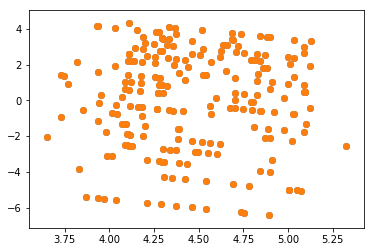

RMSE=2.761211303675778


/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



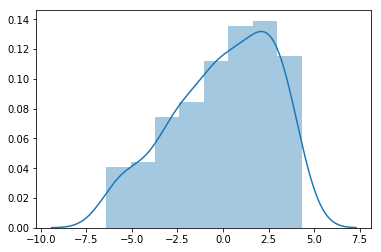

In [93]:
regression_evaluation(yt, xt)

In [39]:
ldf[(ldf.euclidean == ldf.euclidean.min())]

,acousticness,album,album_id,album_release,artist,danceability,energy,feature,key,loudness,tempo,track_id,track_name,valence,cos_similarity,e_1,e_2,e_3,e_4,euclidean
135,0.683,Let Me In Your Life,6Buhu2InRlKvtGC63NU2fC,1974-02-25,Aretha Franklin,0.664,0.634,No Feature,0.181818,-6.348,93.914,3iX0BMs9dX9CsgrHhiB173,Until You Come Back To Me [That's What I Am Go...,0.666,0.926634,0.461955,0.661543,0.079101,0.393358,0.079101


In [40]:
ldf = ldf.drop_duplicates('track_name')
rec = ldf.nsmallest(15,'euclidean')

In [41]:
rec

,acousticness,album,album_id,album_release,artist,danceability,energy,feature,key,loudness,tempo,track_id,track_name,valence,cos_similarity,e_1,e_2,e_3,e_4,euclidean
125,0.6580,Aretha (1980),10K47n89LYsn4jZm9Zzald,1980,Aretha Franklin,0.329,0.582,No Feature,0.545455,-5.548,107.186,0xXH73mgW4Kc1dRZrHZHBE,United Together,0.456,0.996914,0.090873,0.324612,0.498744,0.499278,0.090873
96,0.7820,The Very Best Of Aretha Franklin - The 70's,2jfJMNfHt2kIqSOyQyq7Jn,1972,Aretha Franklin,0.647,0.617,No Feature,0.181818,-8.901,95.004,1PbB82yaidq8X0XPhLlBek,Until You Come Back To Me [That's What I Am Go...,0.654,0.927615,0.451388,0.661199,0.091406,0.378466,0.091406
356,0.4550,The Very Best Of Aretha Franklin - The 70's,2jfJMNfHt2kIqSOyQyq7Jn,1972,Aretha Franklin,0.520,0.454,No Feature,0.090909,-10.616,110.480,2c3HrTyXKraoTdTlDBXpar,I'm In Love,0.326,0.921908,0.450052,0.813527,0.422534,0.093683,0.093683
203,0.7550,Soul Queen,3nIxtIMxYqCiD7ZDE0payb,2007-10-29,Aretha Franklin,0.270,0.577,No Feature,0.000000,-8.195,170.250,6hpATujo25ozqubXszUxwR,Angel,0.362,0.844092,0.530740,0.865768,0.359336,0.102433,0.102433
101,0.3340,Aretha Franklin Sings The Great Diva Classics,6GDaEPN935WkElYXTR6Ejd,2014-10-17,Aretha Franklin,0.543,0.568,No Feature,0.000000,-6.486,104.173,2sc45qVuZpUr44nCq06RDV,Nothing Compares 2 U,0.376,0.846028,0.530043,0.863615,0.348948,0.109062,0.109062
18,0.0473,Aretha Franklin Sings The Great Diva Classics,6GDaEPN935WkElYXTR6Ejd,2014-10-17,Aretha Franklin,0.654,0.679,No Feature,0.727273,-5.460,107.961,0UdRGHCSRvn85nN0IfHFmq,Rolling In the Deep (The Aretha Version),0.592,0.991686,0.323368,0.110031,0.621776,0.729646,0.110031
90,0.0646,A Brand New Me: Aretha Franklin (with The Roya...,5ugc0oyFijTzQG3nHwRJ7A,2017-11-10,Aretha Franklin,0.400,0.535,Royal Philharmonic Orchestra,0.181818,-9.881,78.227,1XhePkOGNnquPQmGbq98s7,Son Of A Preacher Man (with The Royal Philharm...,0.279,0.951350,0.360925,0.728277,0.437696,0.110841,0.110841
418,0.4960,Rare & Unreleased Recordings From The Golden R...,2oyxkNkpfi9anarmactB1a,2007-10-15,Aretha Franklin,0.530,0.478,No Feature,0.090909,-7.785,110.656,78onml5umFMhmgmcmmHzjw,I'm In Love - Alternate Vocal - Let Me In Your...,0.401,0.915752,0.443879,0.787990,0.346130,0.121463,0.121463
65,0.0850,A Brand New Me: Aretha Franklin (with The Roya...,5ugc0oyFijTzQG3nHwRJ7A,2017-11-10,Aretha Franklin,0.560,0.707,Royal Philharmonic Orchestra,0.000000,-7.553,109.189,5vW4aaWSi5xdPyRPLdfeQ3,Don't Play That Song (You Lied) [with The Roya...,0.666,0.845426,0.625778,0.840993,0.123730,0.408665,0.123730
31,0.2570,Aretha Franklin Sings The Great Diva Classics,6GDaEPN935WkElYXTR6Ejd,2014-10-17,Aretha Franklin,0.551,0.512,No Feature,0.454545,-6.889,95.024,5nSzvsTiu2hIYKGrDn141h,At Last,0.282,0.985772,0.123836,0.503888,0.554253,0.383033,0.123836


In [42]:
trace1 = go.Scatter3d(
    x=x_cent,
    y=y_cent,
    z=z_cent,
    mode='markers',
    marker=dict(
        size=18,
        color='blue',                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)

trace2 = go.Scatter3d(
    x=ldf[features[0]],
    y=ldf[features[1]],
    z=ldf[features[2]],
    mode='markers',
    marker=dict(
        size=12,
        color='red',                # set color to an array/list of desired values
        colorscale='Earth',   # choose a colorscale
        opacity=0.4
    ),text= ldf['track_name']
)


data = [trace1,trace2]
layout = go.Layout(
                    scene = dict(
                    xaxis = dict(
                        title=features[0]),
                    yaxis = dict(
                        title=features[1]),
                    zaxis = dict(
                        title=features[2]),),
                    width=700,
                    margin=dict(
                    r=20, b=10,
                    l=10, t=10)
                  )
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='plot from API (17)')



In [43]:
id_add = list(rec['track_id'].to_dict().values())

In [28]:
token2 = call_api('mrethana', 'playlist-modify-public')
sp2 = spotipy.Spotify(auth=token2)



            User authentication requires interaction with your
            web browser. Once you enter your credentials and
            give authorization, you will be redirected to
            a url.  Paste that url you were directed to to
            complete the authorization.

        
Opening https://accounts.spotify.com/authorize?client_id=4849430a2b114eae9d8eaf2c1f14f612&response_type=code&redirect_uri=http%3A%2F%2F127.0.0.1%3A8050%2Fdashboard&scope=playlist-modify-public in your browser


Enter the URL you were redirected to: https://accounts.spotify.com/authorize?client_id=4849430a2b114eae9d8eaf2c1f14f612&response_type=code&redirect_uri=http%3A%2F%2F127.0.0.1%3A8050%2Fdashboard&scope=playlist-modify-public




SpotifyOauthError: Bad Request

In [97]:
token = call_api('mrethana', 'user-top-read')
sp = spotipy.Spotify(auth=token)
# input('http://127.0.0.1:8050/dashboard?code=AQBnrGOn6GkHA0SYj7nadp-sCydBgpm5Y_laPI05mrkBLQD5xTtyaSX5jkoUk_4ZFLh4xB-0hBybST0w-yIYXYqewyamHzEST81hNgdNzWRL3JidvtbrTIkfQ9EddhaAKnt5-r3e0iLdbioa2PXgSwOotZ70ajQA8lu6H95XaJEBMEmQHeBn3i4WUEuZAITiX6j48bTcBp4BfqnHEzxYkhkbN6NBSVUl_y955_k')



            User authentication requires interaction with your
            web browser. Once you enter your credentials and
            give authorization, you will be redirected to
            a url.  Paste that url you were directed to to
            complete the authorization.

        
Opened https://accounts.spotify.com/authorize?client_id=4849430a2b114eae9d8eaf2c1f14f612&response_type=code&redirect_uri=http%3A%2F%2F127.0.0.1%3A8050%2Fdashboard&scope=user-top-read in your browser


Enter the URL you were redirected to: http://127.0.0.1:8050/dashboard?code=AQCHN65WJGKH3xeuQ4pRHkIzmy3Efs2X0Bd9wbcequufNubIY4YiNTjXbwxYQX7n9dbcQ61waFM2FF5pCzDEmZdKLkMGBaJhKtzNSpfLzOr5UX8AIDRWhCBUbKj0jrTR9kaZ9sFRkqgTUvY47AxbMISnjbE_VaCM14gWd9tWis-0bGp-WEx3F2Cq8d6qHnRdp5AOHcO53gPN-z_st33y5ZeoiY8




In [45]:
return_to_dict = rec['artist'].to_dict()
artist_name = list(return_to_dict.values())[0]
artist_name

'Aretha Franklin'

In [46]:
sp2.user_playlist_create('mrethana',artist_name, True)

{'collaborative': False,
 'description': None,
 'external_urls': {'spotify': 'https://open.spotify.com/user/mrethana/playlist/4Dy1yITjkv7FwhAWZZ9g3Q'},
 'followers': {'href': None, 'total': 0},
 'href': 'https://api.spotify.com/v1/users/mrethana/playlists/4Dy1yITjkv7FwhAWZZ9g3Q',
 'id': '4Dy1yITjkv7FwhAWZZ9g3Q',
 'images': [],
 'name': 'Aretha Franklin',
 'owner': {'display_name': None,
  'external_urls': {'spotify': 'https://open.spotify.com/user/mrethana'},
  'href': 'https://api.spotify.com/v1/users/mrethana',
  'id': 'mrethana',
  'type': 'user',
  'uri': 'spotify:user:mrethana'},
 'primary_color': None,
 'public': True,
 'snapshot_id': 'MSxlNDA1ZjYxMDAzZGUxNzUyMWE1ZGJlMWQwNjg2ZWViMWYzN2MzNWNh',
 'tracks': {'href': 'https://api.spotify.com/v1/users/mrethana/playlists/4Dy1yITjkv7FwhAWZZ9g3Q/tracks',
  'items': [],
  'limit': 100,
  'next': None,
  'offset': 0,
  'previous': None,
  'total': 0},
 'type': 'playlist',
 'uri': 'spotify:user:mrethana:playlist:4Dy1yITjkv7FwhAWZZ9g3Q'}

In [47]:
newest_id = sp2.user_playlists('mrethana')['items'][0]['id']

In [48]:
sp2.user_playlist_add_tracks('mrethana', newest_id, id_add, None)

{'snapshot_id': 'MixjOGJkZjVkMWQyNTE0MmM5ZWY4N2VjZjA5YzcxNDc5YWFhMGM4ZTk0'}

In [ ]:
input('Enter - ')
if len(url) < 1: url = 'http://py4e-data.dr-chuck.net/known_by_Rhuairidh.html'